# BrainSight

We propose a neural network model intended to help in detecting different stages of Alzheimer's disease.

The model was trained on a dataset of 6400 MRI immages divided into 4 classes according to the severity of disease : NonDemented, VeryMildDemented, MildDemented, ModerateDemented.

In [1]:
!pip install split-folders
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# imports
import os
import tensorflow as tf 

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.offline as py
import plotly.tools as tls

import pathlib
from pathlib import Path

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

import pandas as pd

import splitfolders

pio.templates.default = "plotly_dark"
matplotlib.style.use('dark_background')

In [3]:
# Importing dataset
data_root_orig = tf.keras.utils.get_file(origin='https://brain-disease-detector.s3.eu-west-3.amazonaws.com/alzheimer_no_split_folders_renamed.zip',
                                         fname='/content/alzheimer.zip',
                                         cache_subdir="/content",
                                         archive_format='zip',
                                         extract=True)

In [4]:
class_names = os.listdir('/content/alzheimer_no_split_folders_renamed')

In [5]:
class_names

['3_ModerateDemented', '0_NonDemented', '2_MildDemented', '1_VeryMildDemented']

In [6]:
# Splitting dataset into training, validation and test sets.
splitfolders.ratio('/content/alzheimer_no_split_folders_renamed', output='/content/output', ratio=(0.64, 0.16, 0.20))

Copying files: 6400 files [00:00, 7436.83 files/s]


In [7]:
image_dir_path = '.'
paths = [path.parts[-3:] for path in
         Path('/content').rglob('*.jpg')]
df = pd.DataFrame(data=paths, columns=['folder', 'class', 'file_name'])
print(df.head(10))
print(df.tail(10))

  folder               class          file_name
0    val  3_ModerateDemented  moderateDem46.jpg
1    val  3_ModerateDemented  moderateDem36.jpg
2    val  3_ModerateDemented         29 (2).jpg
3    val  3_ModerateDemented   moderateDem5.jpg
4    val  3_ModerateDemented  moderateDem38.jpg
5    val  3_ModerateDemented  moderateDem47.jpg
6    val  3_ModerateDemented         30 (2).jpg
7    val  3_ModerateDemented  moderateDem22.jpg
8    val  3_ModerateDemented   moderateDem1.jpg
9    val  3_ModerateDemented  moderateDem27.jpg
                                   folder               class  \
12790  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12791  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12792  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12793  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12794  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12795  alzheimer_no_split_folders_renamed  1_VeryMildDemented   
12796  alzheimer_

In [8]:
df.groupby(['folder', 'class']).size()

folder                              class             
alzheimer_no_split_folders_renamed  0_NonDemented         3200
                                    1_VeryMildDemented    2240
                                    2_MildDemented         896
                                    3_ModerateDemented      64
test                                0_NonDemented          640
                                    1_VeryMildDemented     449
                                    2_MildDemented         180
                                    3_ModerateDemented      14
train                               0_NonDemented         2048
                                    1_VeryMildDemented    1433
                                    2_MildDemented         573
                                    3_ModerateDemented      40
val                                 0_NonDemented          512
                                    1_VeryMildDemented     358
                                    2_MildDemented         143


In [9]:
# Checking whether the percentage of different classes it the same between train, validation and test sets
df[df["folder"]=="train"].groupby(["class"]).size()/len(df[df["folder"]=="train"])

class
0_NonDemented         0.500244
1_VeryMildDemented    0.350024
2_MildDemented        0.139961
3_ModerateDemented    0.009770
dtype: float64

In [10]:
df[df["folder"]=="val"].groupby(["class"]).size()/len(df[df["folder"]=="val"])

class
0_NonDemented         0.500489
1_VeryMildDemented    0.349951
2_MildDemented        0.139785
3_ModerateDemented    0.009775
dtype: float64

In [11]:
df[df["folder"]=="test"].groupby(["class"]).size()/len(df[df["folder"]=="test"])

class
0_NonDemented         0.498831
1_VeryMildDemented    0.349961
2_MildDemented        0.140296
3_ModerateDemented    0.010912
dtype: float64

In [12]:
#Defining image dataset 
train_image_generator = ImageDataGenerator(rescale=1/255)

val_image_generator = ImageDataGenerator(rescale=1/255)

test_image_generator = ImageDataGenerator(rescale=1/255)


train_dataset = train_image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/output/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 class_mode='categorical')

validation_dataset = val_image_generator.flow_from_directory(batch_size=8,
                                                 directory='/content/output/val',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 class_mode='categorical')

test_dataset = test_image_generator.flow_from_directory(batch_size=1300,
                                                 directory='/content/output/test',
                                                 shuffle=True,
                                                 target_size=(176,208))

Found 4094 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1283 images belonging to 4 classes.


In [13]:
train_images, train_labels = train_dataset.next()

In [14]:
print(train_labels)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [15]:
validation_images, validation_labels = validation_dataset.next()

In [16]:
print(validation_labels)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [17]:
test_images, test_labels = test_dataset.next()

In [18]:
print(test_labels)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [19]:
train_dataset.class_indices

{'0_NonDemented': 0,
 '1_VeryMildDemented': 1,
 '2_MildDemented': 2,
 '3_ModerateDemented': 3}

In [20]:
test_dataset.class_indices

{'0_NonDemented': 0,
 '1_VeryMildDemented': 1,
 '2_MildDemented': 2,
 '3_ModerateDemented': 3}

In [21]:
class_indices = {v:k for k,v in train_dataset.class_indices.items()}

Class :  0_NonDemented


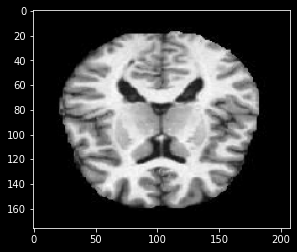

Class :  0_NonDemented


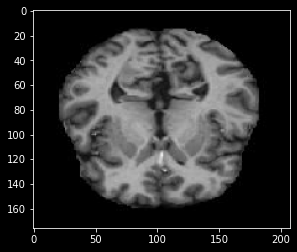

Class :  1_VeryMildDemented


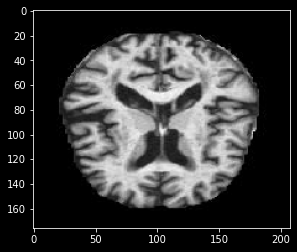

Class :  0_NonDemented


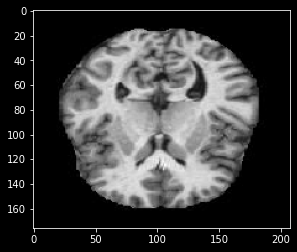

Class :  1_VeryMildDemented


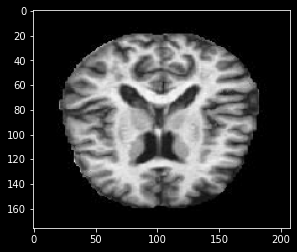

Class :  1_VeryMildDemented


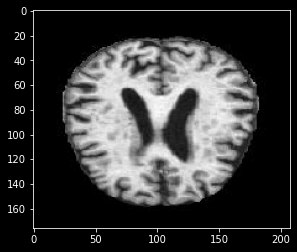

Class :  1_VeryMildDemented


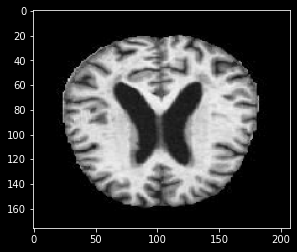

Class :  2_MildDemented


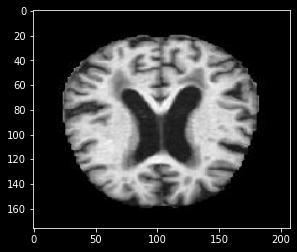

In [22]:
# Visualising several images of the dataset
imgs, targets = next(iter(train_dataset))

for i, (img, target) in enumerate(zip(imgs, targets)):
  print('Class : ', class_indices[np.argmax(target)])
  plt.imshow(img)
  plt.show()

### Model building

In [23]:

model = tf.keras.Sequential([

     Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = "same",
            activation = "relu", input_shape = (176, 208, 3)), # the input shape (height, width, channels)
     MaxPool2D(pool_size=2, # the size of the pooling window
               strides=2), # the movement of the pooling on the input
     Dropout(0.1),
     Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = "same",
            activation = "relu"),
     MaxPool2D(2,2),
     Dropout(0.1),
     Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = "same",
            activation = "relu"),
     MaxPool2D(2,2),
     Dropout(0.1),
     tf.keras.layers.Flatten(), # this layer turns multi-dimensional images into flat objects
     tf.keras.layers.Dense(128, activation="relu"),
     Dropout(0.1),
     tf.keras.layers.Dense(64, activation="relu"),
     tf.keras.layers.Dense(4, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 104, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 104, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 104, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 52, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 44, 52, 32)        0

In [24]:
# Defining metrics and optimization
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4)
    ]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=False)


In [25]:
initial_learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

In [26]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 104, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 104, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 104, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 52, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 44, 52, 32)        0

### Model training

In [27]:

EPOCHS = 50

history = model.fit(train_dataset, validation_data=validation_dataset,shuffle=True, epochs=EPOCHS)


Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


512/512 [==============================] - 12s 13ms/step - loss: 0.9895 - acc: 0.5264 - auc: 0.8133 - f1_score: 0.2631 - val_loss: 0.8869 - val_acc: 0.5846 - val_auc: 0.8517 - val_f1_score: 0.3119
Epoch 2/50
512/512 [==============================] - 7s 13ms/step - loss: 0.8265 - acc: 0.6282 - auc: 0.8740 - f1_score: 0.3965 - val_loss: 0.7161 - val_acc: 0.6931 - val_auc: 0.9124 - val_f1_score: 0.5019
Epoch 3/50
512/512 [==============================] - 6s 12ms/step - loss: 0.5849 - acc: 0.7601 - auc: 0.9390 - f1_score: 0.5801 - val_loss: 0.4272 - val_acc: 0.8348 - val_auc: 0.9700 - val_f1_score: 0.8429
Epoch 4/50
512/512 [==============================] - 6s 12ms/step - loss: 0.3350 - acc: 0.8666 - auc: 0.9797 - f1_score: 0.8236 - val_loss: 0.2876 - val_acc: 0.9032 - val_auc: 0.9856 - val_f1_score: 0.8816
Epoch 5/50
512/512 [==============================] - 6s 12ms/step - loss: 0.1979 - acc: 0.9282 - auc: 0.9924 - f1_score: 0.9167 - val_loss: 0.2110 - val_acc: 0.9238 - val_auc: 0.990

### Performance evaluation

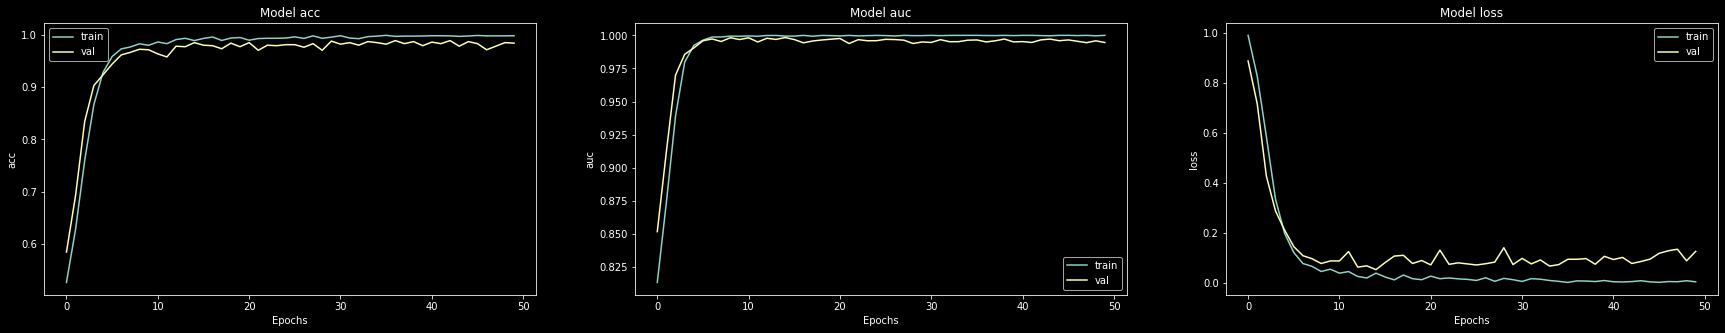

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
fig.show()

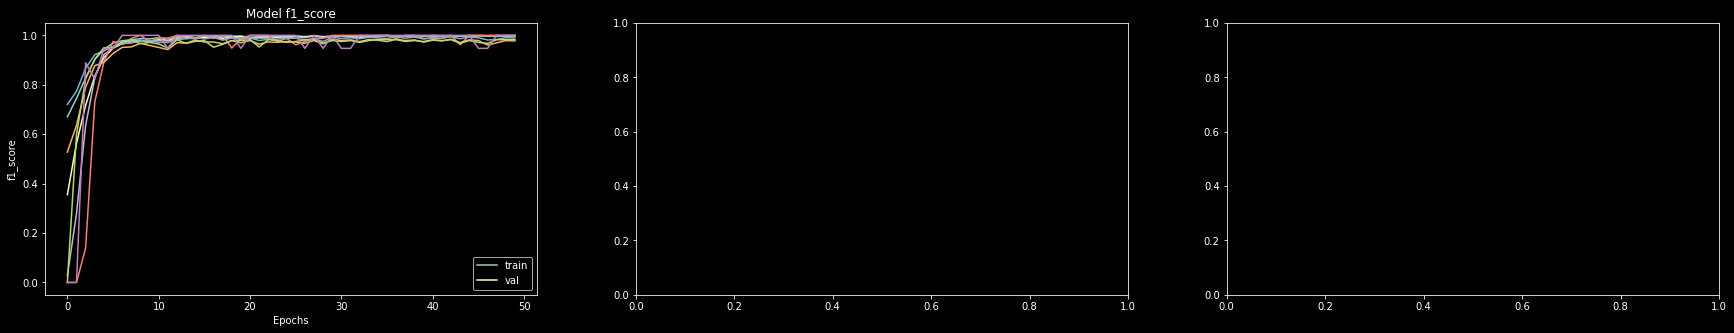

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["f1_score"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [30]:
train_dataset.class_indices.values()

dict_values([0, 1, 2, 3])

In [31]:
type(train_dataset.class_indices.values())

dict_values

In [32]:
# test dataset class_indices
test_dataset.class_indices

{'0_NonDemented': 0,
 '1_VeryMildDemented': 1,
 '2_MildDemented': 2,
 '3_ModerateDemented': 3}

In [33]:
# Evaluation on validation dataset
_ = model.evaluate(validation_dataset)

128/128 [==============================] - 1s 9ms/step - loss: 0.1262 - acc: 0.9844 - auc: 0.9946 - f1_score: 0.9873


In [34]:
# Evaluation on test dataset
_ = model.evaluate(test_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.1469 - acc: 0.9766 - auc: 0.9930 - f1_score: 0.9798


In [35]:
test_images, test_labels = test_dataset.next()

In [36]:
test_dataset.class_indices.keys()

dict_keys(['0_NonDemented', '1_VeryMildDemented', '2_MildDemented', '3_ModerateDemented'])

In [37]:
test_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [38]:
len(test_labels)

1283

In [39]:
#Predicting the test data
predicted_labels = model.predict(test_dataset)

1/1 [==============================] - 2s 2s/step


In [40]:
predicted_labels

array([[1.0000000e+00, 3.1603481e-08, 1.7769372e-13, 3.3775760e-17],
       [9.9981648e-01, 1.8352225e-04, 7.3662054e-10, 3.0419578e-10],
       [1.0000000e+00, 3.5720278e-09, 3.9915687e-18, 4.8986334e-20],
       ...,
       [9.9999809e-01, 1.8647337e-06, 3.1731015e-10, 7.1331897e-14],
       [2.1524608e-10, 1.0000000e+00, 1.0909061e-09, 4.1864387e-15],
       [1.0000000e+00, 1.0857192e-12, 3.2425144e-16, 9.2630116e-21]],
      dtype=float32)

In [41]:
predicted_labels = np.argmax(predicted_labels, axis=1)

In [42]:
predicted_labels

array([0, 0, 0, ..., 0, 1, 0])

In [43]:
test_labels = np.argmax(test_labels, axis=1)

In [44]:
test_labels

array([0, 0, 0, ..., 0, 1, 0])

In [45]:
target_names = [k + ' : ' + str(v) for k,v in test_dataset.class_indices.items()]

In [46]:
target_names

['0_NonDemented : 0',
 '1_VeryMildDemented : 1',
 '2_MildDemented : 2',
 '3_ModerateDemented : 3']

In [47]:
print(classification_report(test_labels, predicted_labels, target_names = target_names))

                        precision    recall  f1-score   support

     0_NonDemented : 0       0.97      1.00      0.98       640
1_VeryMildDemented : 1       0.98      0.96      0.97       449
    2_MildDemented : 2       0.99      0.94      0.97       180
3_ModerateDemented : 3       1.00      1.00      1.00        14

              accuracy                           0.98      1283
             macro avg       0.98      0.98      0.98      1283
          weighted avg       0.98      0.98      0.98      1283



(array([0, 1, 2, 3]),
 [Text(0, 0, '0_NonDemented : 0'),
  Text(1, 0, '1_VeryMildDemented : 1'),
  Text(2, 0, '2_MildDemented : 2'),
  Text(3, 0, '3_ModerateDemented : 3')])

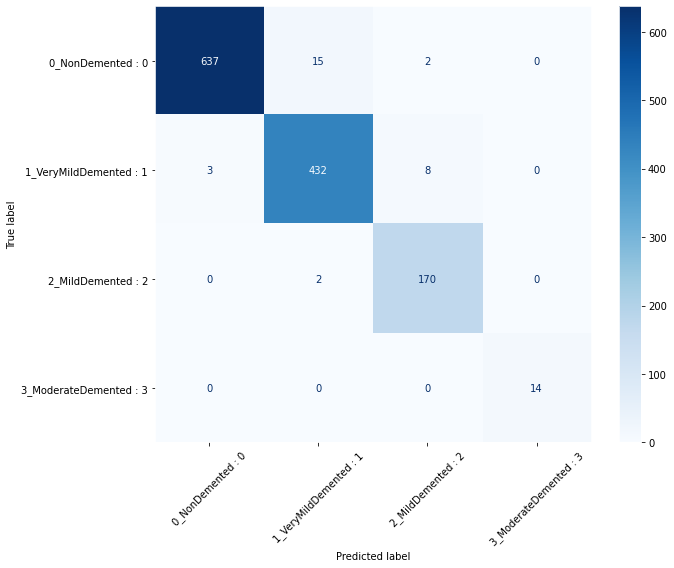

In [48]:
cm = confusion_matrix(predicted_labels, test_labels)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black", 'xtick.color': "black", 'ytick.color': "black"})
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation = 45)


In [49]:
#Saving the model for future use
custom_cnn_model_dir = './models/' + "alzheimer_cnn_dropout_layers_lazy_adam.h5"
model.save(custom_cnn_model_dir, save_format='h5')
os.listdir('./models')

['alzheimer_cnn_dropout_layers_lazy_adam.h5']

### Grad-Cam visualisation

In [50]:
class_indices = validation_dataset.class_indices
indices = {v:k for k,v in class_indices.items()}

In [51]:
from sklearn.metrics import classification_report

In [52]:
filenames = validation_dataset.filenames

In [53]:
y_val = validation_dataset.classes
y_pred = model.predict(validation_dataset)
y_pred = np.argmax(y_pred,axis=1)

128/128 [==============================] - 1s 9ms/step


In [54]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,0_NonDemented/26 (69).jpg,0_NonDemented,1_VeryMildDemented,False
1,0_NonDemented/26 (82).jpg,0_NonDemented,0_NonDemented,True
2,0_NonDemented/26 (99).jpg,0_NonDemented,1_VeryMildDemented,False
3,0_NonDemented/27 (14).jpg,0_NonDemented,2_MildDemented,False
4,0_NonDemented/27 (21).jpg,0_NonDemented,0_NonDemented,True
5,0_NonDemented/27 (22).jpg,0_NonDemented,2_MildDemented,False
6,0_NonDemented/27 (29).jpg,0_NonDemented,0_NonDemented,True
7,0_NonDemented/27 (30).jpg,0_NonDemented,1_VeryMildDemented,False
8,0_NonDemented/27 (36).jpg,0_NonDemented,0_NonDemented,True
9,0_NonDemented/27 (46).jpg,0_NonDemented,0_NonDemented,True


In [55]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [57]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"/content/output/val/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

In [58]:
img_size = 32

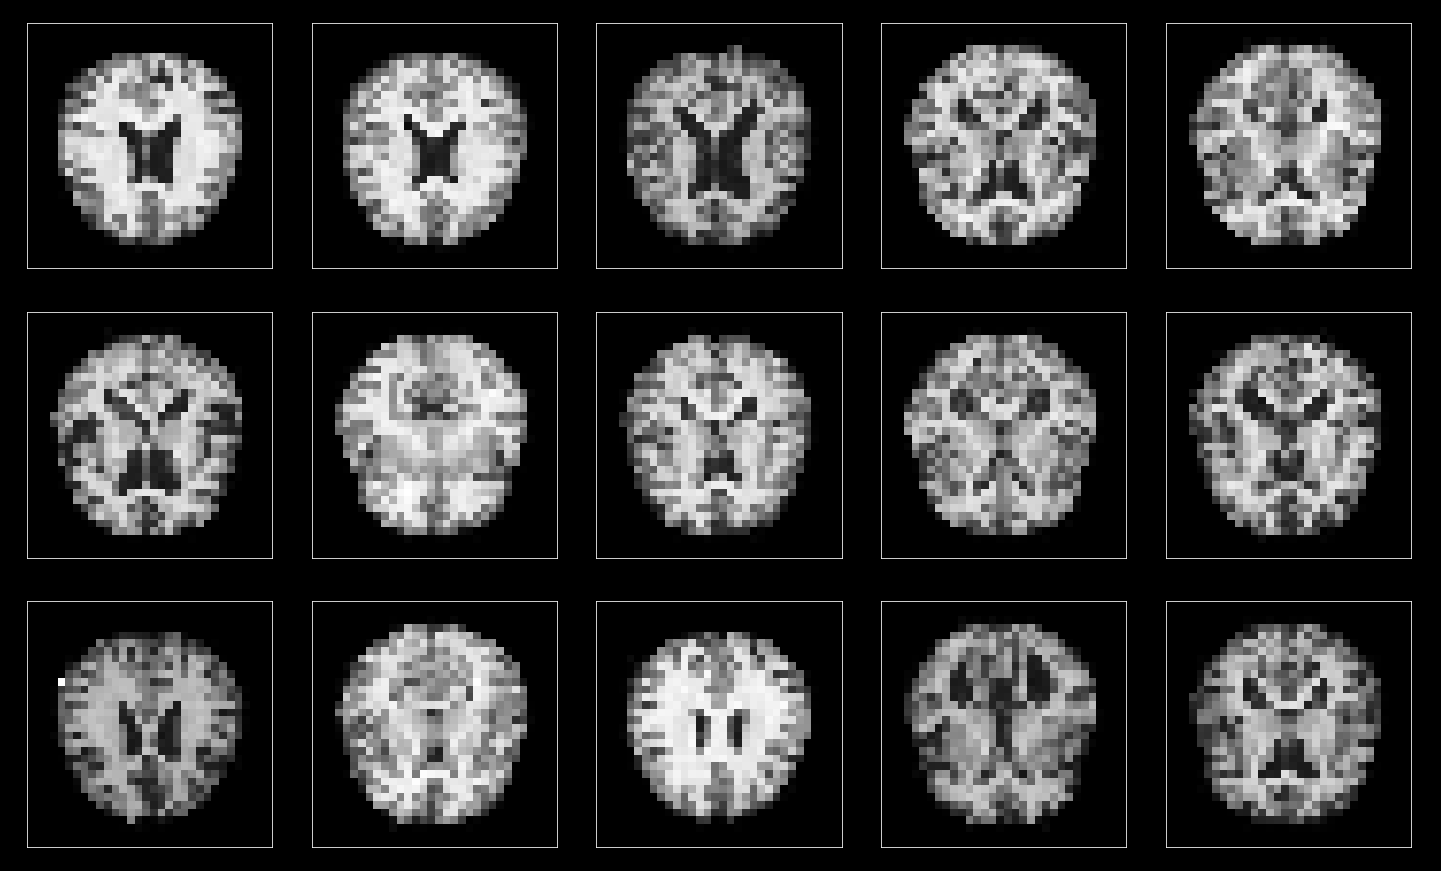

In [59]:
display_images(val_df[val_df['Same']==True])

In [60]:
model.layers

In [61]:
model.layers[-8]

In [62]:
model.output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense_2')>

In [63]:
model.layers[-4]

In [64]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[model.layers[-8].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



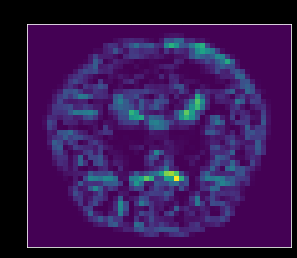

In [65]:
heatmaps = []

for img in imgs:
  heatmap = make_gradcam_heatmap(
      tf.expand_dims(img, axis=0), model
  )
  heatmaps.append(heatmap)

# Display heatmap
plt.matshow(heatmaps[0])
plt.show()

In [66]:
imgs, labels = validation_dataset.next()

In [67]:
pred_labels = model.predict(imgs)

1/1 [==============================] - 0s 101ms/step


In [68]:
validation_dataset.class_indices.items()

dict_items([('0_NonDemented', 0), ('1_VeryMildDemented', 1), ('2_MildDemented', 2), ('3_ModerateDemented', 3)])

In [69]:
class_indices

{'0_NonDemented': 0,
 '1_VeryMildDemented': 1,
 '2_MildDemented': 2,
 '3_ModerateDemented': 3}

Predicted label: 0_NonDemented
True label: 1_VeryMildDemented


<ipython-input-70-0c4d70603574>:30: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



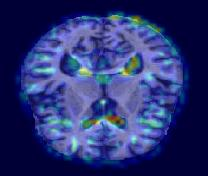

Predicted label: 0_NonDemented
True label: 0_NonDemented


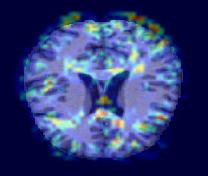

Predicted label: 0_NonDemented
True label: 0_NonDemented


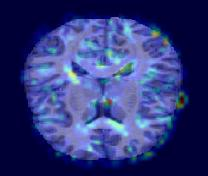

Predicted label: 0_NonDemented
True label: 0_NonDemented


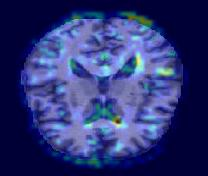

Predicted label: 0_NonDemented
True label: 0_NonDemented


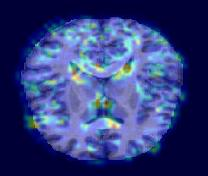

Predicted label: 0_NonDemented
True label: 2_MildDemented


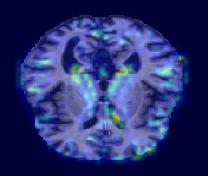

Predicted label: 0_NonDemented
True label: 0_NonDemented


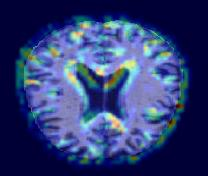

Predicted label: 0_NonDemented
True label: 0_NonDemented


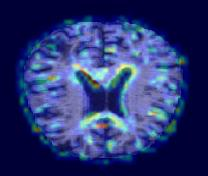

In [70]:
from pathlib import Path
from matplotlib import cm
from IPython.display import Image

for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps):
  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.003 + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "saved_img.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  pred_file_path = np.argmax(validation_dataset.labels == pred_label)
  pred_label_name = Path(validation_dataset.filepaths[pred_file_path]).parent.name

  true_file_path = np.argmax(validation_dataset.labels == tf.argmax(true_label))
  true_label_name = Path(validation_dataset.filepaths[true_file_path]).parent.name

  print("Predicted label:",pred_label_name)
  print("True label:", true_label_name)

  display(Image(save_path))